In [8]:
library(ggplot2)
library(forcats)
library(purrr)

Warning message:
"le package 'forcats' a été compilé avec la version R 4.5.2"
Warning message:
"le package 'purrr' a été compilé avec la version R 4.5.2"


In [81]:
# Charger les données
df <- read.csv("../../Données/data_cleaned.csv")

In [11]:
vars_factor <- c("Region", "Regulated.Dam", "Primary.Purpose", "Primary.Type", "Spillway", "Hazard",
                "Assessment", "Length_missing", "Volume_missing", "n_modifications", "last_modification_year")
df[vars_factor] <- lapply(df[vars_factor], as.factor)
summary(df)

      ID                   Region     Regulated.Dam
 Length:19368       Flumevale :3074   No : 8123    
 Class :character   Lyndrassia:7920   Yes:11245    
 Mode  :character   Navaldia  :8374                
                                                   
                                                   
                                                   
                                                   
                                   Primary.Purpose Primary.Type 
 Recreation                                :4248   Earth:19368  
 Flood Risk Reduction                      :3983                
 Fire Protection, Stock, Or Small Fish Pond:2878                
 Irrigation                                :2822                
 Water Supply                              :2169                
 Unknow                                    : 934                
 (Other)                                   :2334                
   Height..m.       Length..km.        Volume..m3.        Year.C

## Région

In [32]:
graph_region <- function(df, perte, region_var = "Region", bins = 30) {
  regions <- unique(df[[region_var]])
  regions <- regions[!is.na(regions)]

  par(mfrow = c(2, length(regions)), bg = "white", mar = c(4, 4, 3, 1))

  # Boxplots (ligne 1)
  for (reg in regions) {
    x <- df[df[[region_var]] == reg, perte]
    x <- x[!is.na(x)]

    boxplot(
      x,
      main = paste(reg),
      ylab = perte,
      col = "gray85",
      border = "gray40"
    )
  }

  # Histogrammes (ligne 2)
  for (reg in regions) {
    x <- df[df[[region_var]] == reg, perte]
    x <- x[!is.na(x)]

    hist(
      x,
      breaks = bins,
      main = paste(reg),
      xlab = perte,
      col = "steelblue",
      border = "white"
    )
  }
}


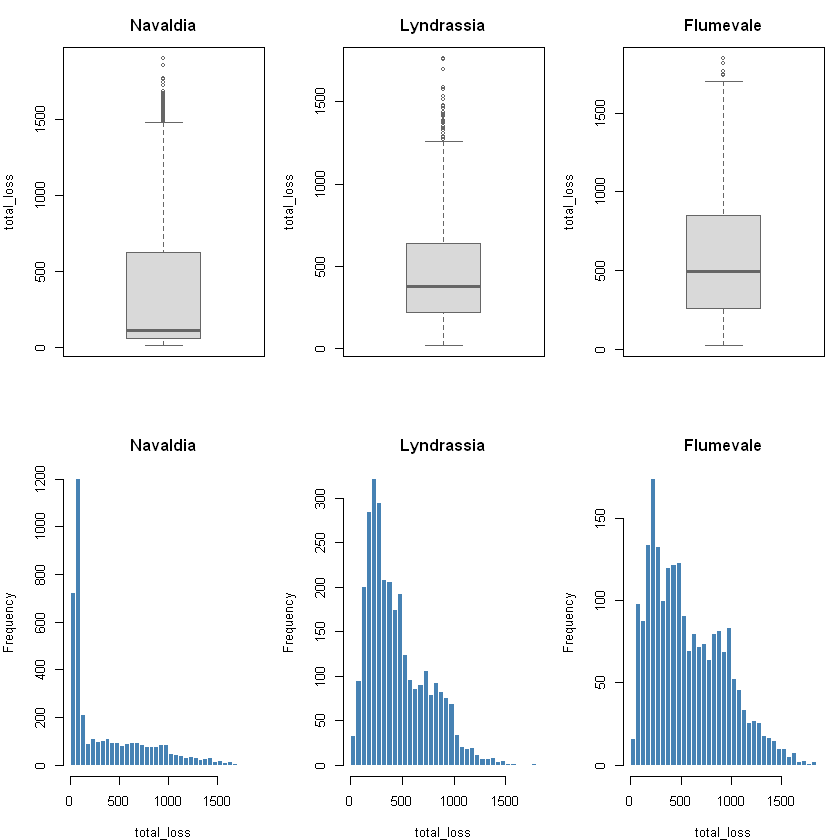

In [33]:
graph_region(df, "total_loss")

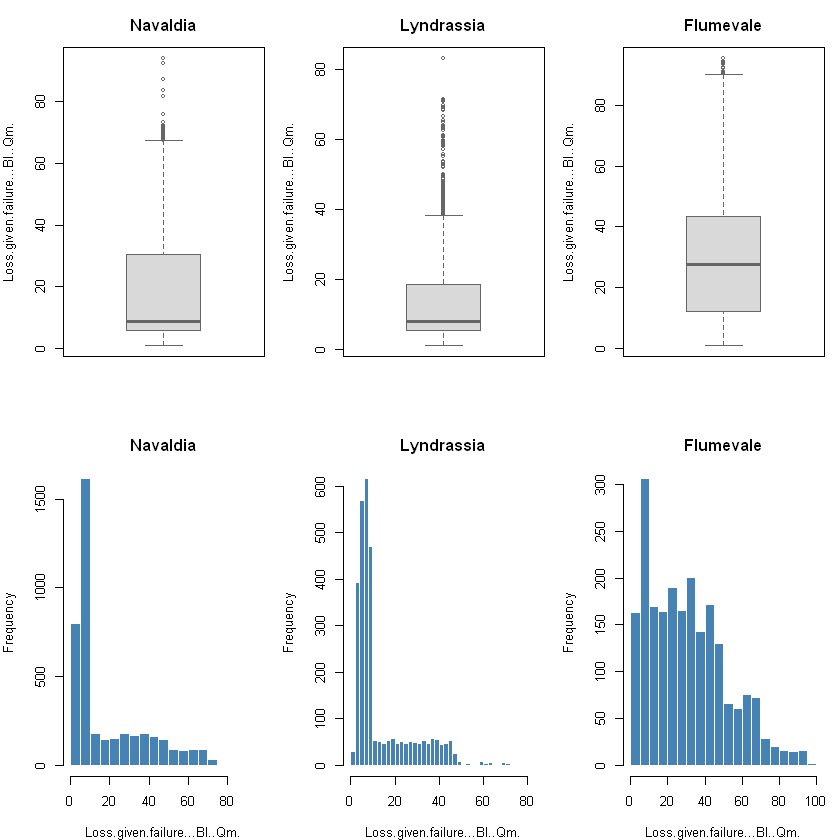

In [34]:
graph_region(df, "Loss.given.failure...BI..Qm.")

Les graphiques montrent que les coûts estimés de réparation en cas de rupture de barrage sont fortement asymétriques, avec une majorité de barrages générant des coûts relativement faibles et quelques cas rares entraînant des pertes très élevées. Cette structure traduit un risque dominé par des événements extrêmes.

Sur le plan régional, Flumevale se distingue par des coûts médians plus élevés et une dispersion plus importante, suggérant des réparations généralement plus coûteuses que dans Navaldia et Lyndrassia, où les coûts sont plus concentrés à des niveaux plus faibles. Toutefois, la présence de valeurs extrêmes dans toutes les régions indique que des réparations très onéreuses restent possibles partout.

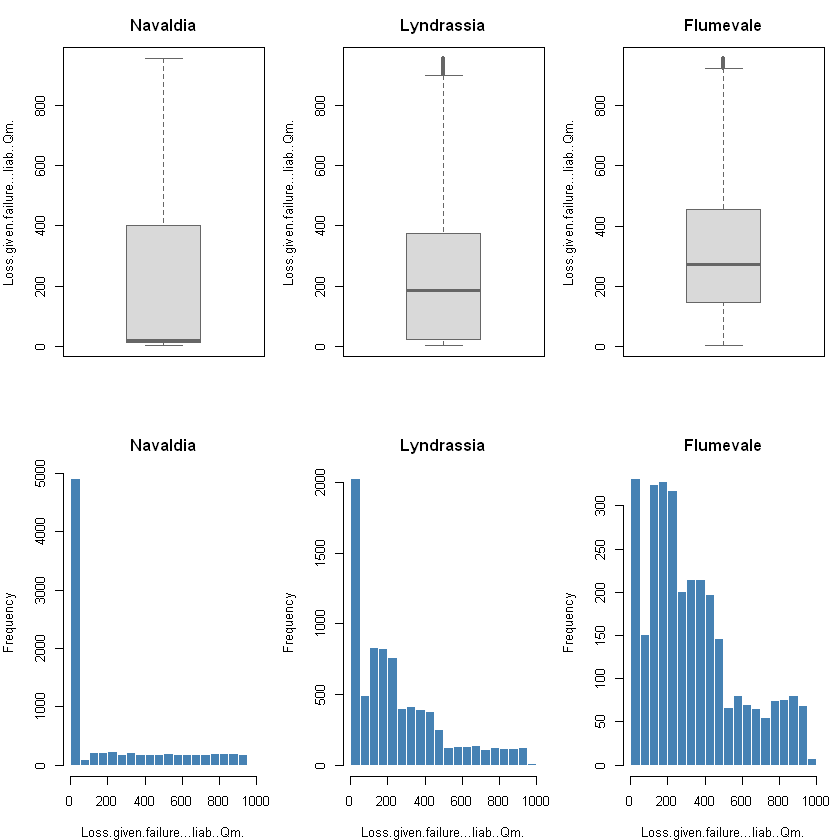

In [35]:
graph_region(df, "Loss.given.failure...liab..Qm.")

Les graphiques indiquent que le coût estimé des dommages causés aux tierces parties, incluant les dommages environnementaux, présente une forte asymétrie dans toutes les régions : la majorité des barrages sont associés à des coûts relativement faibles, tandis que quelques cas rares entraînent des pertes très élevées.

Sur le plan régional, Flumevale affiche les niveaux de coûts les plus élevés, avec une médiane et une dispersion supérieures à celles de Lyndrassia et surtout de Navaldia, où les coûts sont davantage concentrés près de zéro (soit moins d'un million). La présence de valeurs extrêmes dans l’ensemble des régions souligne toutefois que des dommages importants aux tiers demeurent possibles, quel que soit le territoire.

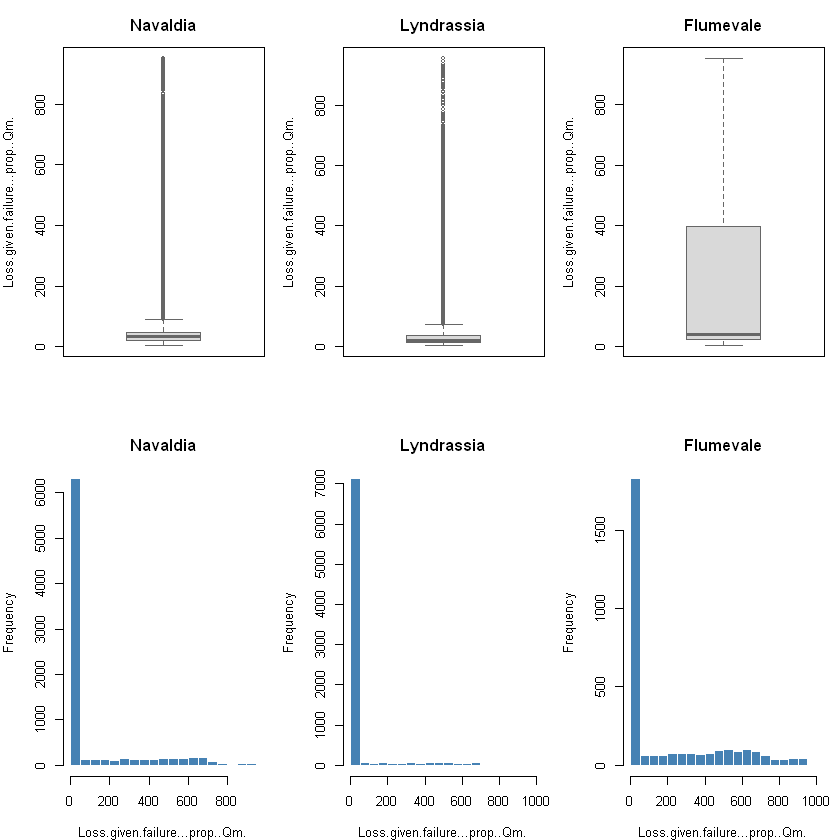

In [37]:
graph_region(df, "Loss.given.failure...prop..Qm.")

Les graphiques montrent que les coûts estimés des revenus annuels perdus dus à l’interruption des affaires sont très fortement concentrés près de zéro (soit moins d'un million) dans Navaldia et Lyndrassia, avec des médianes faibles et une majorité d’observations correspondant à des interruptions limitées ou faibles. Toutefois, la présence de quelques valeurs très élevées indique que, même dans ces régions, des pertes économiques majeures peuvent survenir dans des scénarios extrêmes.

À l’inverse, Flumevale se distingue par une dispersion beaucoup plus large et une médiane plus élevée, suggérant que les interruptions d’activité y entraînent plus fréquemment des pertes substantielles de revenus. Les histogrammes confirment une distribution étalée sur des montants élevés, traduisant une exposition économique plus importante en cas de rupture.

Dans l’ensemble, ces résultats soulignent que les pertes liées à l’interruption des affaires sont dominées par des événements rares mais coûteux, et qu’elles constituent une composante clé du risque économique total, particulièrement dans les régions où l’activité économique dépend fortement des infrastructures hydrauliques.

In [129]:
prob_expo_plot <- function(df, var,
                           prob_var = "Probability.of.Failure",
                           vertical_labels = TRUE,
                           sort_by = c("exposure", "prob", "none")) {
  
  sort_by <- match.arg(sort_by)

  # Expositions et probabilités
  expo  <- table(df[[var]])
  means <- tapply(df[[prob_var]], df[[var]], mean, na.rm = TRUE)

  # Alignement
  cats <- intersect(names(expo), names(means))
  expo  <- expo[cats]
  means <- means[cats]

  # Tri
  if (sort_by == "exposure") {
    o <- order(expo, decreasing = TRUE)
  } else if (sort_by == "prob") {
    o <- order(means, decreasing = TRUE)
  } else {
    o <- seq_along(cats)
  }
  expo  <- expo[o]
  means <- means[o]
  cats  <- names(expo)

  # Paramètres graphiques
  par(
    bg = "white",
    mar = c(if (vertical_labels) 12 else 6, 6, 4, 8),
    las = if (vertical_labels) 2 else 1
  )

  # BARPLOT : expositions (axe gauche)
  bp <- barplot(
    expo,
    names.arg = cats,
    col = "gray80",
    border = "gray50",
    ylab = "Exposition (nombre de barrages)",
    main = paste("Exposition et probabilité moyenne de brisure selon", var)
  )

  # Grille 
  grid(nx = NA, ny = NULL, lty = 3, col = "gray85")

  # COURBE : probabilité moyenne (axe droit)
  par(new = TRUE)
  plot(
    bp, means,
    type = "b",
    pch = 19,
    col = "steelblue4",
    lwd = 2,
    axes = FALSE,
    xlab = "",
    ylab = "",
    ylim = c(0, max(means, na.rm = TRUE) * 1.15)
  )

  axis(4, col = "steelblue4", col.axis = "steelblue4")
  mtext(
    "Probabilité",
    side = 4,
    line = 3,
    col = "steelblue4"
  )

  # Valeurs numériques sur la courbe
  text(
    bp, means,
    labels = round(means, 3),
    pos = 3,
    cex = 0.85,
    col = "steelblue4"
  )

  invisible(list(exposure = expo, mean_prob = means))
}

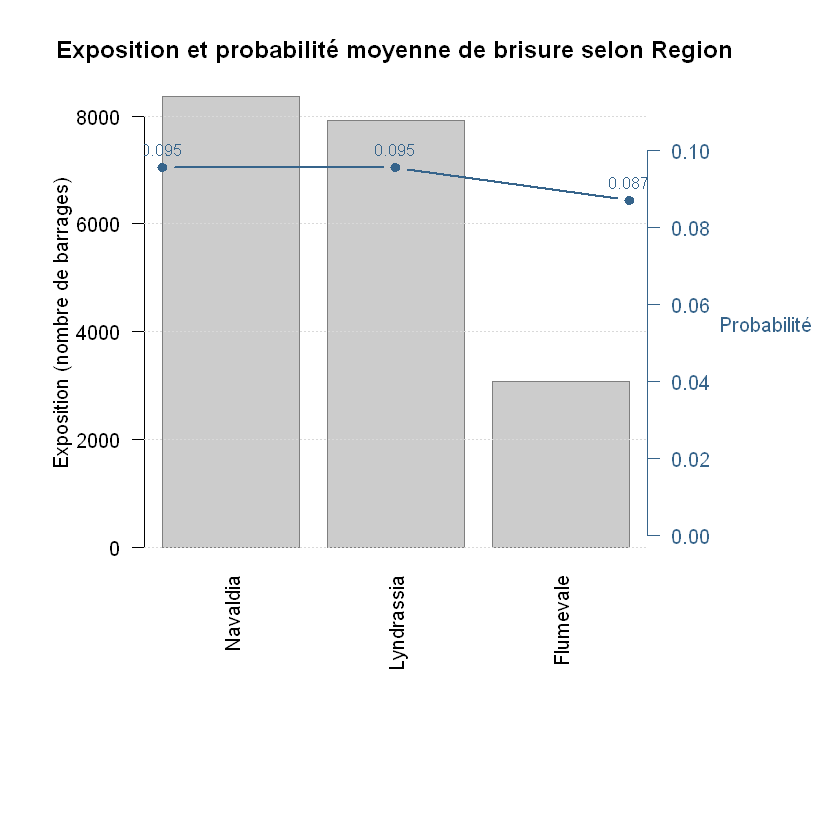

In [130]:
prob_expo_plot(df, "Region")

Le graphique montre que la probabilité moyenne de brisure est globalement similaire entre les régions, avec des valeurs comprises entre 8,7 % et 9,5 %. Flumevale présente la probabilité moyenne la plus faible (~ 0,087), tandis que Lyndrassia et Navaldia affichent des valeurs légèrement plus élevées et très proches l’une de l’autre (~0,095). Ces écarts restent toutefois modérés, ce qui suggère que la région, prise isolément, n’explique qu’une part limitée des différences de probabilité de brisure.


## Régulation des barrages 

In [150]:
analyse_cat <- function(df, var, perte, bins = 30) {
  modalite <- unique(df[[var]])
  modalite <- modalite[!is.na(modalite)]
  
  k <- length(modalite)
  if (k == 0) stop("Aucune modalité valide pour ", var)

  ncol <- ceiling(sqrt(k))
  nrow <- ceiling(k / ncol)

  cols_mod <- seq_len(k) + 1

  op <- par(no.readonly = TRUE)
  on.exit(par(op), add = TRUE)

  par(bg = "white", mar = c(4, 4, 3, 1))

  # 1) BOXPLOTS
  par(mfrow = c(nrow, ncol))
  for (i in seq_along(modalite)) {
    xi <- df[df[[var]] == modalite[i], perte]
    xi <- xi[is.finite(xi)]          # retire NA/Inf

    if (length(xi) == 0) {           # rien à tracer
      plot.new()
      title(main = as.character(modalite[i]))
      text(0.5, 0.5, "Aucune donnée")
      next
    }

    boxplot(xi, main = as.character(modalite[i]), ylab = perte, col = cols_mod[i])
  }

  # 2) HISTOGRAMMES
  par(mfrow = c(nrow, ncol))
  for (i in seq_along(modalite)) {
    xi <- df[df[[var]] == modalite[i], perte]
    xi <- xi[is.finite(xi)]

    if (length(xi) == 0) {
      plot.new()
      title(main = as.character(modalite[i]))
      text(0.5, 0.5, "Aucune donnée")
      next
    }

    hist(xi, breaks = bins, main = as.character(modalite[i]), xlab = perte,
         col = cols_mod[i], border = "white")
  }
}


In [143]:
pertes <- c("Loss.given.failure...BI..Qm.", "Loss.given.failure...liab..Qm.", "Loss.given.failure...prop..Qm.")

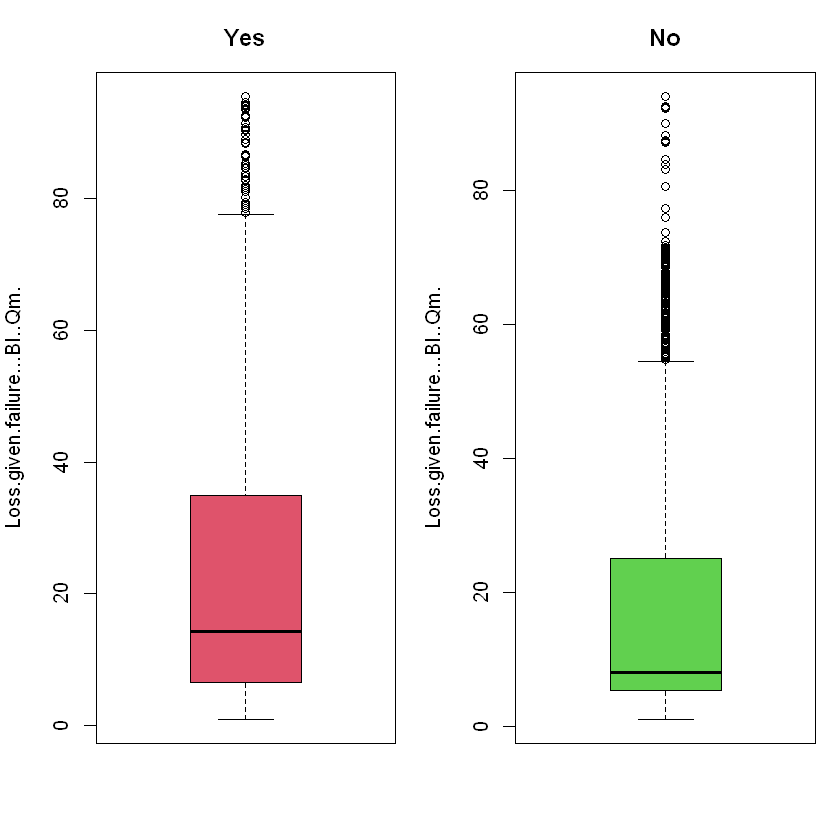

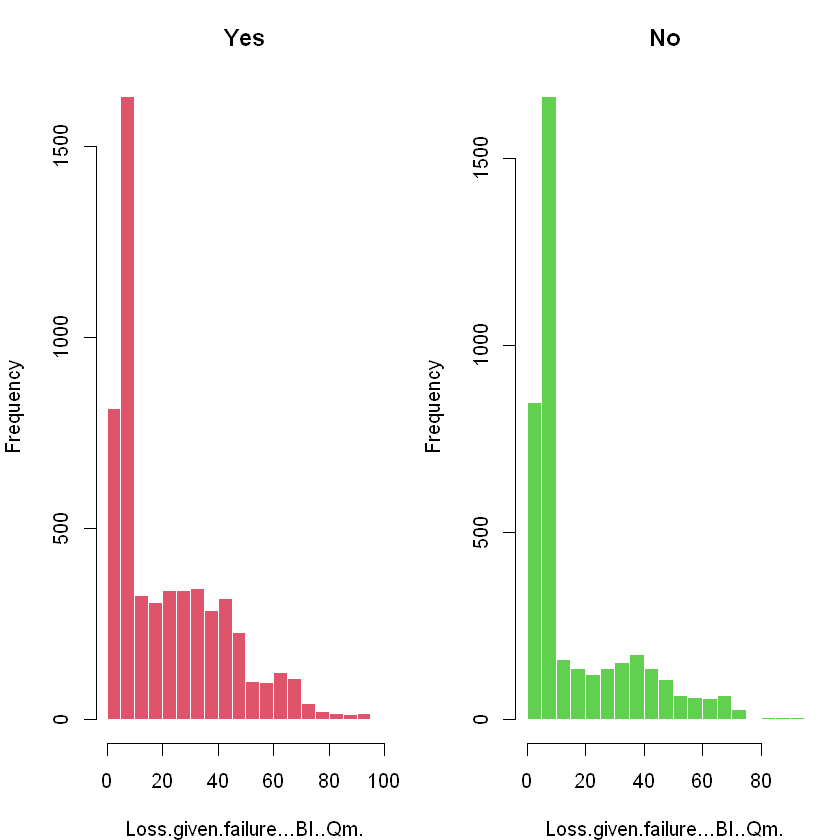

In [152]:
analyse_cat(df, "Regulated.Dam", pertes[1])

Les graphiques montrent que les pertes liées à l’interruption des affaires présentent une forte asymétrie à droite, quelle que soit la modalité ou la région : la majorité des barrages engendrent des pertes relativement faibles, mais quelques cas rares entraînent des pertes très élevées. Cette structure indique un risque dominé par des événements extrêmes.

En comparant les barrages réglementés et non réglementés, on observe que les barrages réglementés ont en général une médiane plus élevée et une dispersion plus importante des pertes. Cela suggère que ces barrages, souvent plus structurants ou situés dans des zones à forte activité économique, peuvent entraîner des pertes d’interruption plus importantes en cas de défaillance, malgré un cadre réglementaire plus strict.

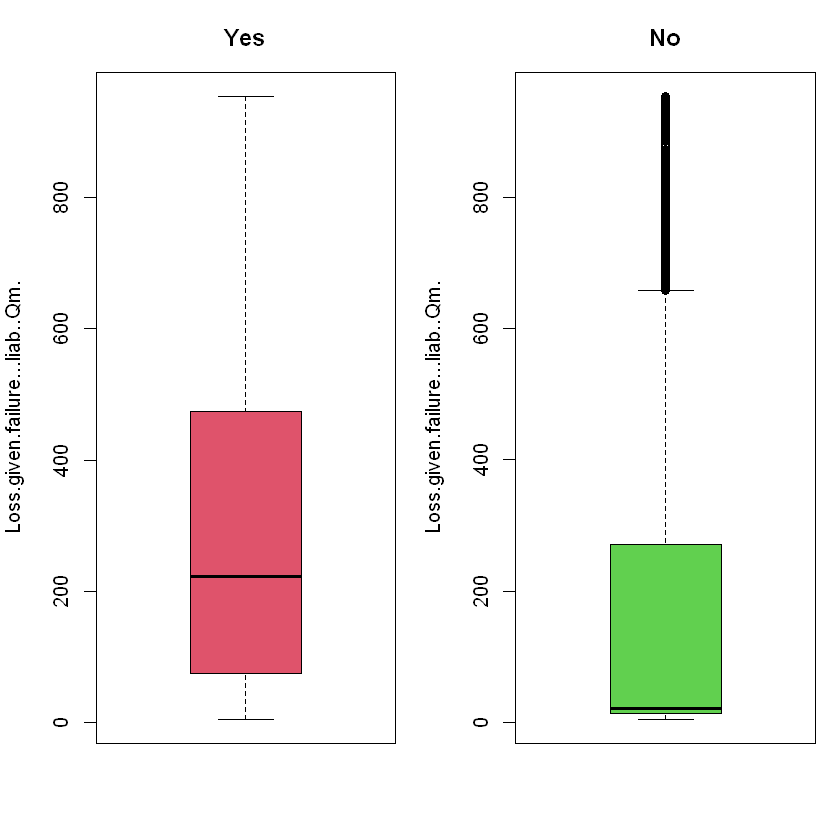

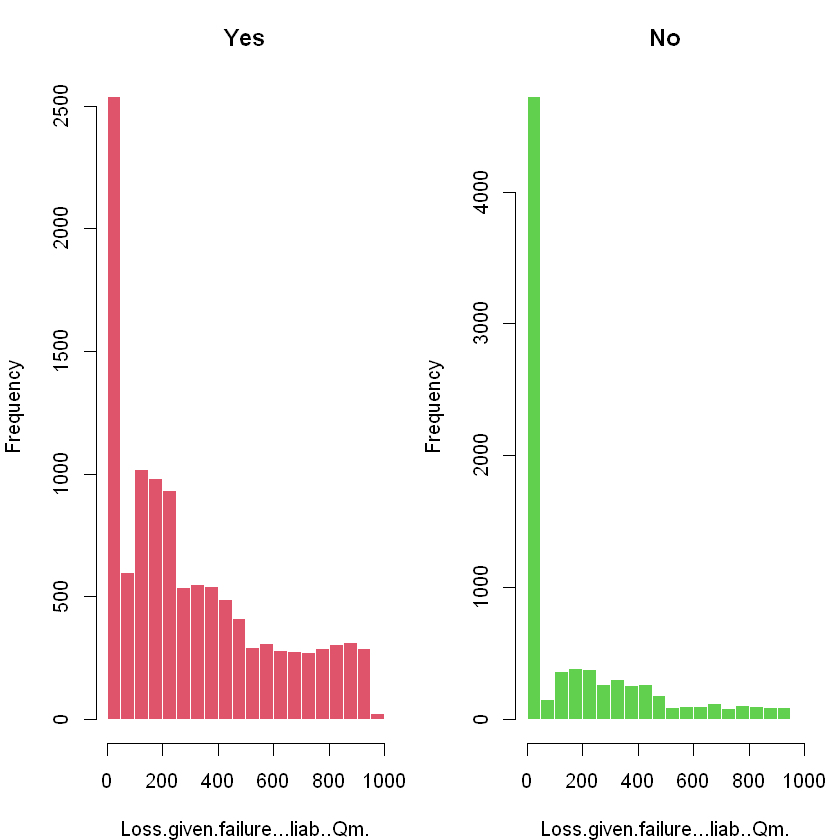

In [153]:
analyse_cat(df, "Regulated.Dam", pertes[2])

Les graphiques montrent que les pertes estimées liées à la responsabilité envers les tiers (_Loss given failure – liab (Qm)_) sont fortement asymétriques, avec une majorité de barrages associés à des coûts faibles et une proportion plus restreinte de cas entraînant des pertes très élevées.

La comparaison selon le statut réglementaire met en évidence des différences notables. Les barrages réglementés présentent une médiane et une dispersion plus élevées des pertes, suggérant que leur défaillance pourrait engendrer des coûts de responsabilité plus importants, possiblement parce qu’ils sont situés dans des environnements plus peuplés ou plus sensibles. À l’inverse, les barrages non réglementés affichent des pertes majoritairement concentrées à de faibles niveaux, bien que la présence de valeurs extrêmes indique que des scénarios de responsabilité coûteux restent possibles.

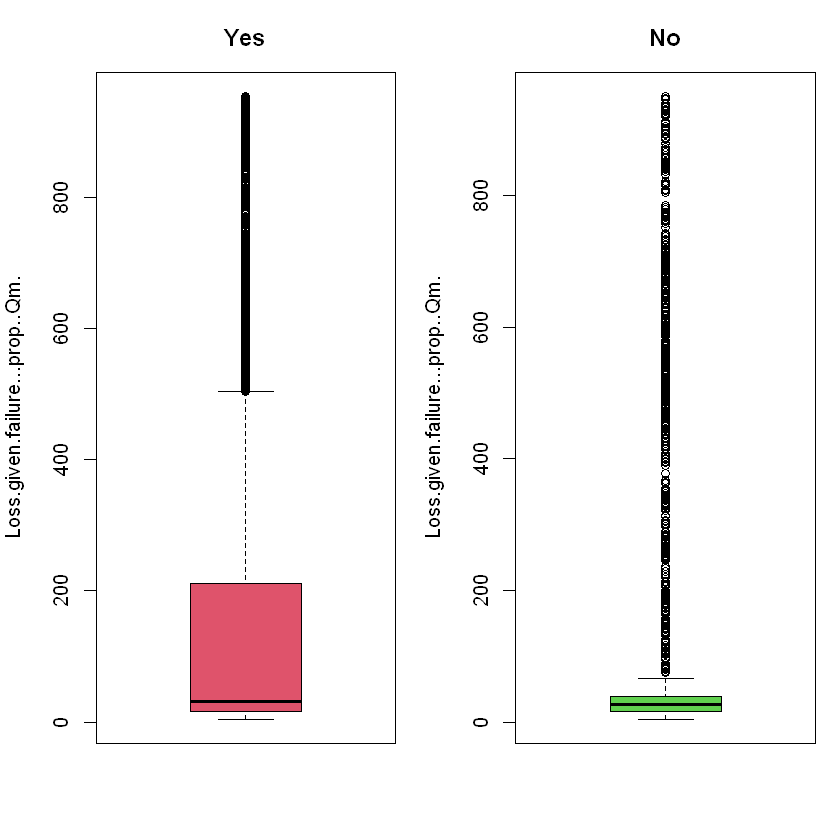

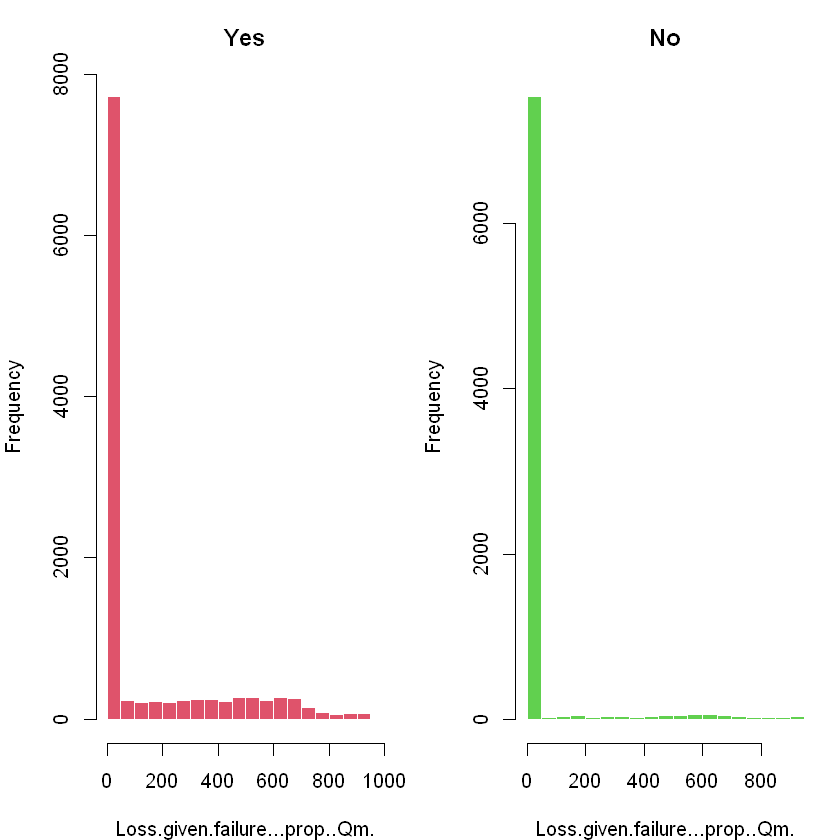

In [154]:
analyse_cat(df, "Regulated.Dam", pertes[3])

Les graphiques indiquent que les pertes estimées liées aux dommages matériels (_property losses_) en cas de rupture de barrage (Loss given failure – prop (Qm)) sont très fortement concentrées à de faibles montants, aussi bien pour les barrages réglementés que non réglementés, avec une asymétrie marquée à droite. La grande majorité des observations correspond à des pertes proches de zéro, tandis qu’un nombre limité de cas entraîne des coûts très élevés.

La comparaison par statut réglementaire montre que les barrages réglementés présentent une dispersion plus importante et des valeurs extrêmes plus élevées, ce qui suggère que leur défaillance peut engendrer des dommages matériels substantiels, probablement en raison d’infrastructures plus importantes ou d’une exposition accrue. À l’inverse, les barrages non réglementés affichent des pertes généralement faibles, mais la présence de quelques valeurs extrêmes rappelle que des dommages matériels significatifs demeurent possibles.

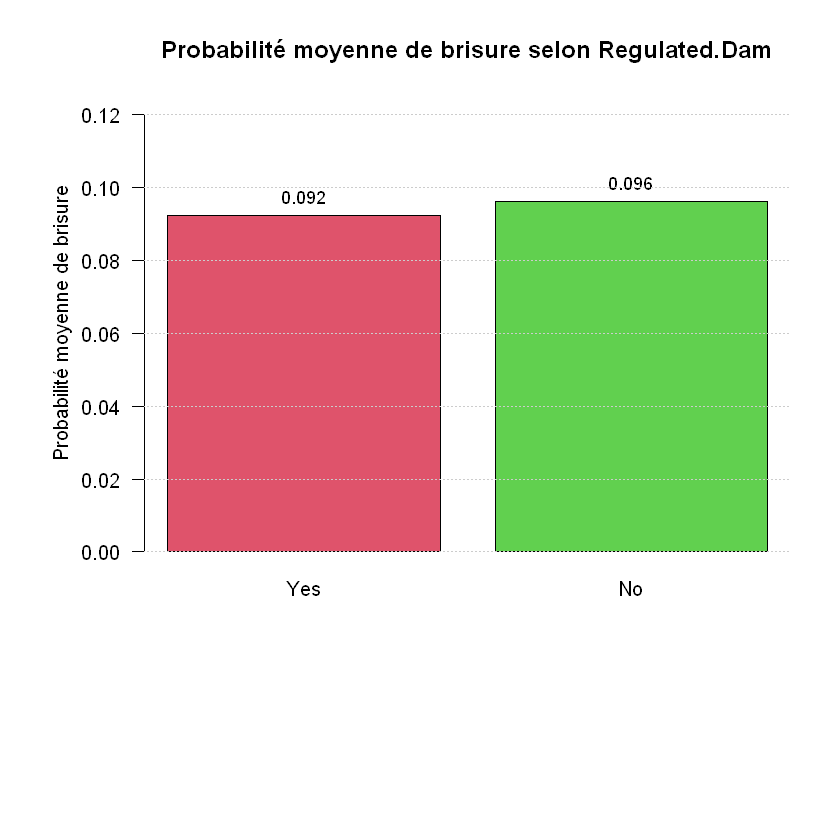

In [155]:
prob_analyse(df, "Regulated.Dam")

Le graphique indique que la probabilité moyenne de brisure est légèrement plus élevée pour les barrages non réglementés (~ 9,6 %) que pour les barrages réglementés (~9,2 %). Cette différence va dans le sens attendu : un cadre réglementaire plus strict est généralement associé à des exigences accrues en matière de conception, d’inspection et de maintenance, ce qui peut contribuer à une réduction du risque de défaillance.

## Utilité première 

In [156]:
df$Primary.Purpose[is.na(df$Primary.Purpose)] <- "Unknown"

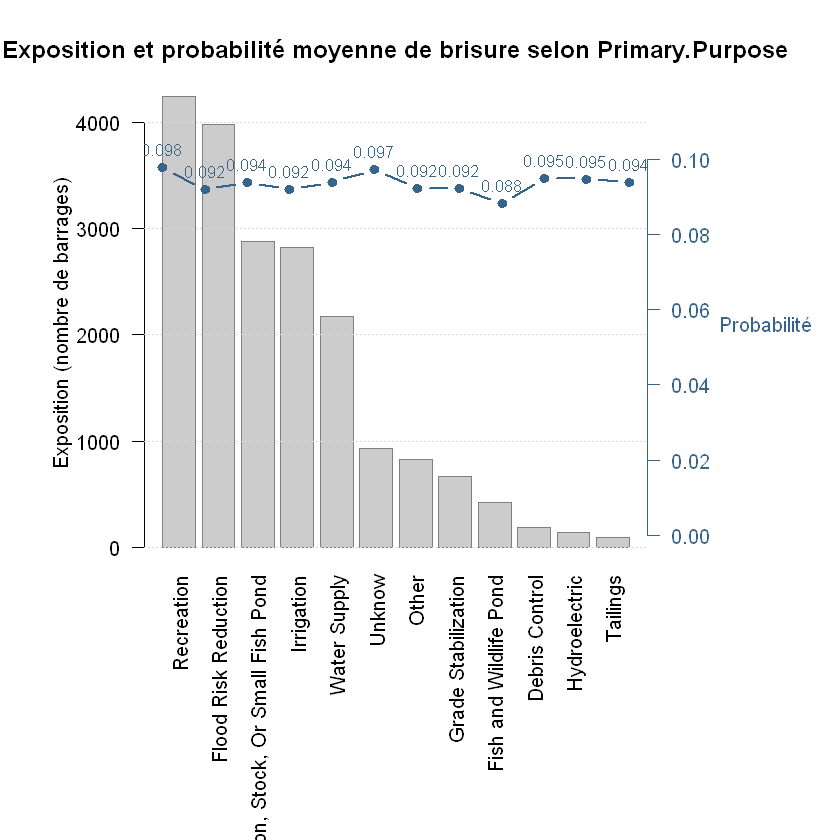

In [157]:
prob_expo_plot(df, "Primary.Purpose",vertical_labels = TRUE)

Le graphique montre que la probabilité moyenne de brisure varie relativement peu selon l’usage principal du barrage, avec des valeurs comprises entre 8,8 % et 9,8 %. À première vue, cela pourrait suggérer que le Primary Purpose n’a qu’un effet limité sur le risque de brisure. Toutefois, cette lecture doit impérativement être nuancée à la lumière des effectifs très hétérogènes observés entre les catégories.

Certaines catégories, telles que Flood Risk Reduction, Recreation, Irrigation et Fire Protection / Small Fish Pond, regroupent plusieurs milliers de barrages. Les probabilités estimées pour ces usages sont donc statistiquement plus stables et plus fiables. À l’inverse, des catégories comme Tailings, Hydroelectric ou Debris Control comptent très peu d’observations. Les probabilités plus élevées observées pour ces groupes doivent être interprétées avec prudence, car elles peuvent être fortement influencées par quelques événements seulement.

## Année de construction 

In [163]:
df$Year.Completed[is.na(df$Year.Completed)] <- "Unknow"

In [186]:
# Moyenne de probabilité par année
prob_by_year <- tapply(
  df$Probability.of.Failure,
  df$Year.Completed,
  mean,
  na.rm = TRUE
)

# Exposition par année
expo_by_year <- table(df$Year.Completed)

# Data frame final bien aligné
year_completed <- data.frame(
  Year.Completed = names(prob_by_year),
  Prob = as.numeric(prob_by_year),
  Exposure = as.numeric(expo_by_year[names(prob_by_year)])
)

year_completed

Year.Completed,Prob,Exposure
<chr>,<dbl>,<dbl>
1748,0.13340000,1
1819,0.09230000,2
1820,0.09946667,3
1825,0.07190000,1
1830,0.12153333,3
1832,0.11030000,1
1835,0.07740000,1
1836,0.11630000,1
1842,0.08995000,2


In [187]:
head(year_completed[order(year_completed$Prob, decreasing = TRUE), ], 10)

,Year.Completed,Prob,Exposure
,<chr>,<dbl>,<dbl>
1,1748,0.1334000,1
16,1854,0.1290000,1
25,1867,0.1282000,1
27,1869,0.1256000,3
12,1849,0.1242000,1
11,1848,0.1219000,1
5,1830,0.1215333,3
38,1881,0.1180600,5
22,1863,0.1172000,2


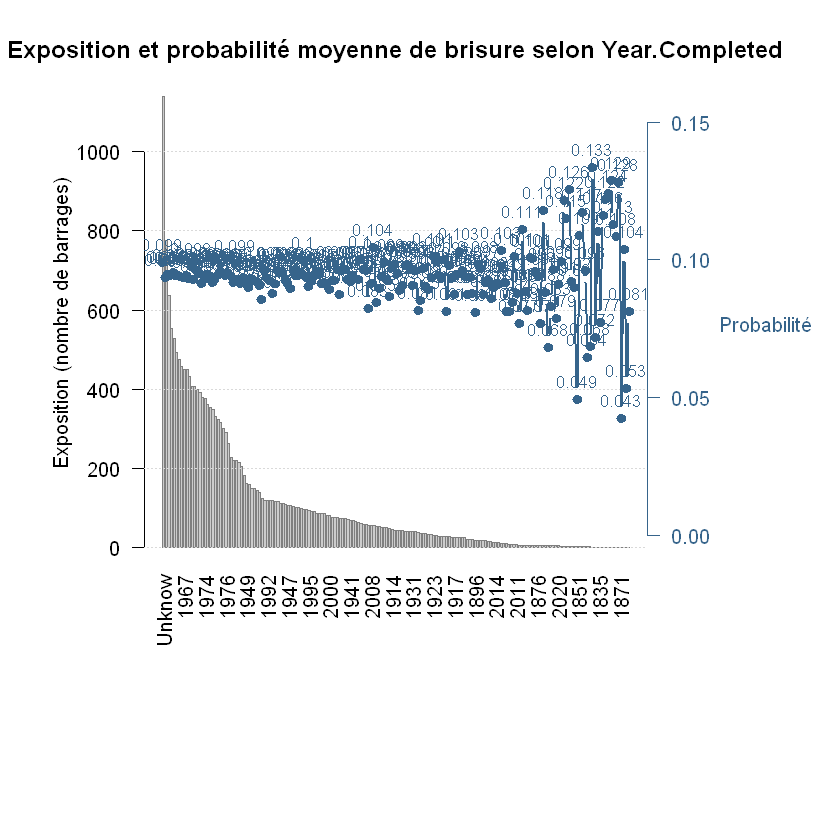

In [188]:
prob_expo_plot(df, "Year.Completed")

Les résultats montrent que les années de construction les plus anciennes présentent les probabilités moyennes de brisure les plus élevées, atteignant parfois plus de 13 %. Toutefois, ces valeurs correspondent à des expositions extrêmement faibles, souvent limitées à un ou deux barrages, ce qui rend ces estimations instables et très sensibles à des observations individuelles. À l’inverse, les années plus récentes concentrent l’essentiel de l’exposition totale du portefeuille, avec des probabilités moyennes de brisure relativement stables autour de 9 à 10 %. la catégorie "Unknown" regroupe de loin la plus grande exposition, c’est-à-dire le plus grand nombre de barrages pour lesquels l’année de construction est inconnue. Malgré cette exposition très élevée, la probabilité moyenne de brisure associée à cette catégorie demeure comparable à celle des années de construction plus récentes, autour de 9–10 %. Cela signifie que, même sans présenter la probabilité la plus élevée individuellement, la catégorie Unknown contribue fortement au risque global du portefeuille en raison de son poids dominant en exposition.

## Année de modification 

In [191]:
df$n_modifications[is.na(df$n_modifications)] <- "Unknow"
df$last_modification_year[is.na(df$last_modification_year)] <- "Unknow"

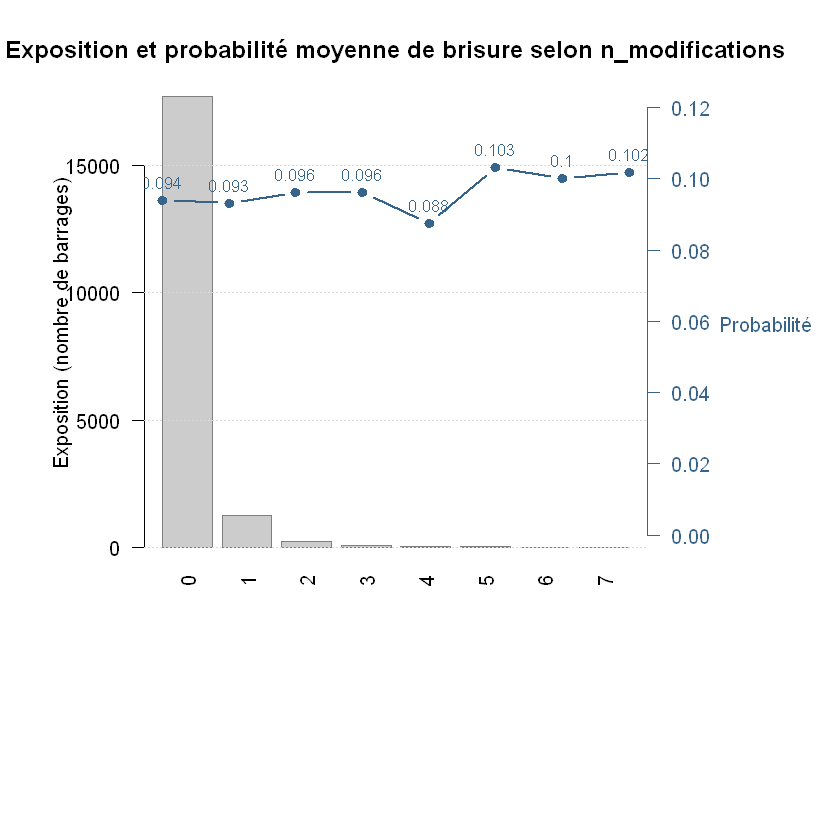

In [192]:
prob_expo_plot(df, "n_modifications")

Le premier graphique montre que la très grande majorité des barrages n’a aucune modification enregistrée, ce qui concentre l’essentiel de l’exposition dans la catégorie 0 modification. La probabilité moyenne de brisure pour ces barrages est relativement stable, autour de 9–10 %. Lorsque le nombre de modifications augmente, l’exposition chute fortement, ce qui rend les estimations plus volatiles. On observe néanmoins une légère tendance à la hausse de la probabilité moyenne pour les barrages ayant plusieurs modifications (5 à 7), dépassant parfois 10 %. Cette augmentation ne doit pas être interprétée comme un effet causal direct des modifications, mais plutôt comme un signal de sélection : les barrages modifiés à répétition sont souvent des ouvrages plus anciens ou plus problématiques, donc intrinsèquement plus risqués.

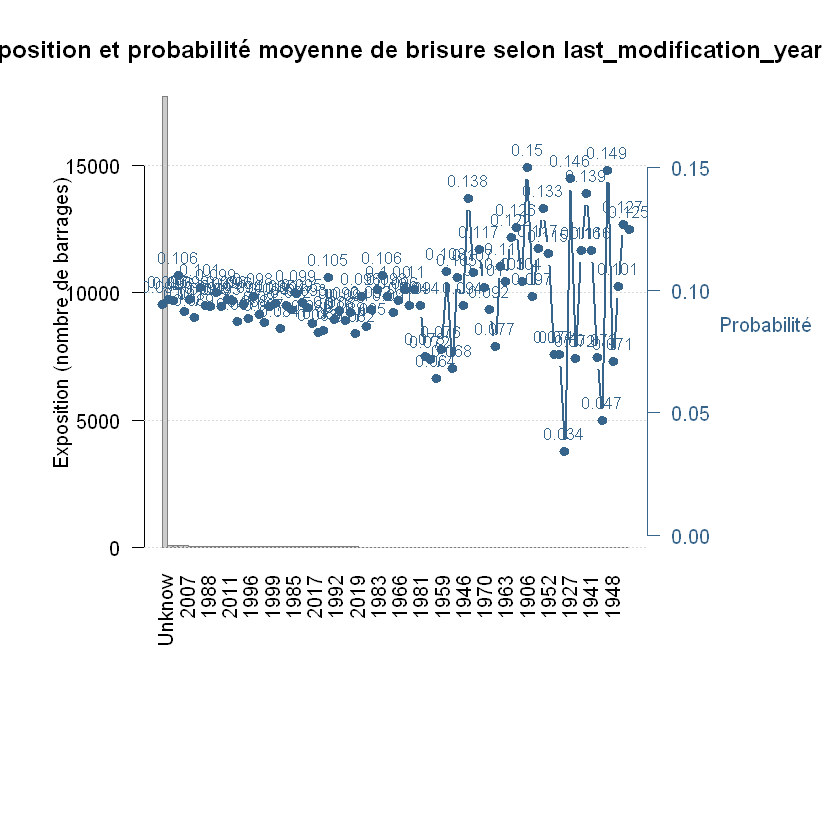

In [193]:
prob_expo_plot(df, "last_modification_year")

Le second graphique met en évidence une exposition très élevée pour la modalité “Unknown”, indiquant qu’une part importante du portefeuille ne dispose pas d’information sur l’année de la dernière modification. Malgré cela, la probabilité moyenne associée à cette catégorie reste proche de 10 %, ce qui en fait un contributeur majeur au risque global. Pour les barrages dont l’année de dernière modification est connue, on observe une forte dispersion des probabilités, en particulier pour les années anciennes, avec des pics pouvant atteindre 13–15 %. Ces valeurs élevées correspondent toutefois à des expositions faibles, ce qui les rend instables. Globalement, les modifications plus récentes semblent associées à des probabilités plus contenues, tandis que les modifications anciennes (ou absentes) traduisent un risque structurel accru, amplifié par l’incertitude et la faible qualité de l’information.

## Spillway

In [194]:
df$Spillway[is.na(df$Spillway)] <- "Unknow"

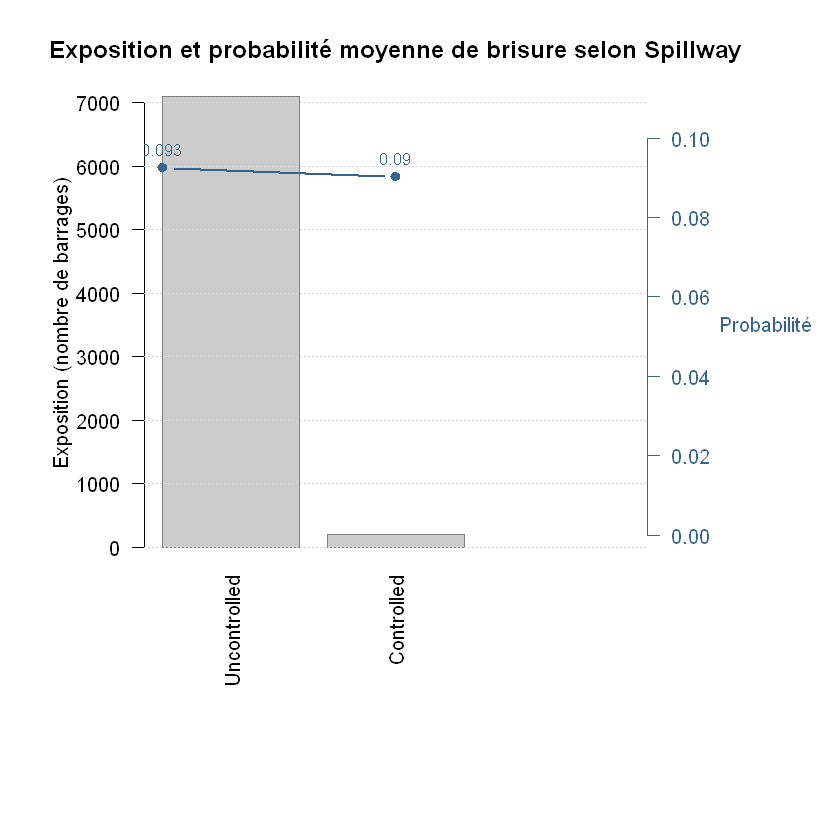

In [195]:
prob_expo_plot(df, "Spillway")

La barrages contrôlés ont une plus faible probabilité de défaillance

## Fréquence des inspections 

In [197]:
df$Inspection.Frequency[is.na(df$Inspection.Frequency)] <- "Unknow"

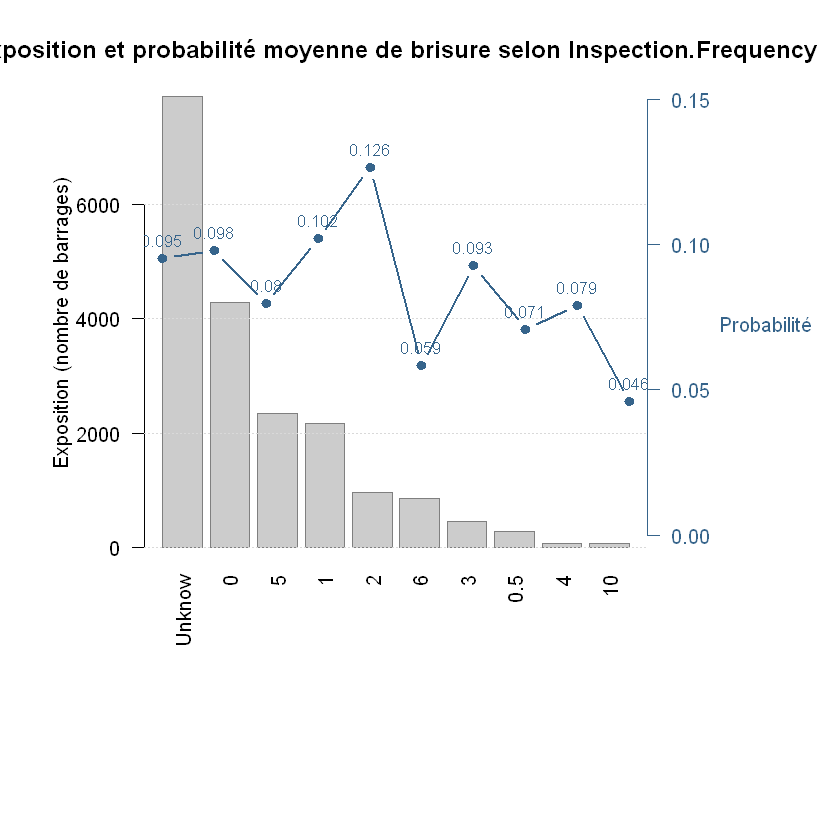

In [198]:
prob_expo_plot(df, "Inspection.Frequency")

In [201]:
data.frame(tapply(df$Probability.of.Failure, df$Inspection.Frequency, mean))

,tapply.df.Probability.of.Failure..df.Inspection.Frequency..mean.
,<dbl>
0,0.09785189
0.5,0.07090433
1,0.10197372
10,0.04598824
2,0.12636563
3,0.09270346
4,0.07898571
5,0.07975738
6,0.05851187


## Risque 

In [202]:
df$Hazard[is.na(df$Hazard)] <- "Undetermined"

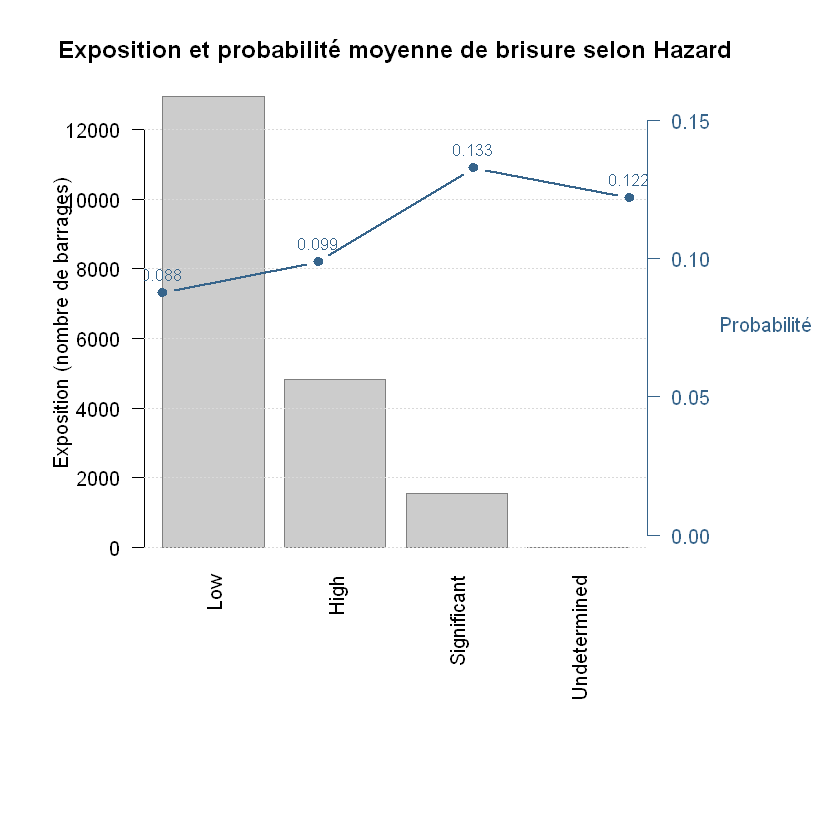

In [203]:
prob_expo_plot(df, "Hazard")

Les barrages classés Low hazard représentent de loin la plus grande part du portefeuille, avec une exposition très élevée, mais une probabilité moyenne de brisure relativement faible (environ 8,8 %). À mesure que le niveau de danger augmente, l’exposition diminue fortement, mais la probabilité moyenne de brisure croît de façon marquée : elle atteint près de 10 % pour les barrages High hazard et culmine à environ 13,3 % pour la catégorie Significant hazard. Cette progression est cohérente avec la logique de classification du danger, qui reflète le potentiel de conséquences en cas de défaillance et, indirectement, des vulnérabilités structurelles plus importantes. La catégorie Undetermined, faiblement exposée, présente une probabilité intermédiaire, mais son poids dans le risque global reste limité.

## Etat du barrage 

In [204]:
df$Assessment[is.na(df$Assessment)] <- "Not Available"

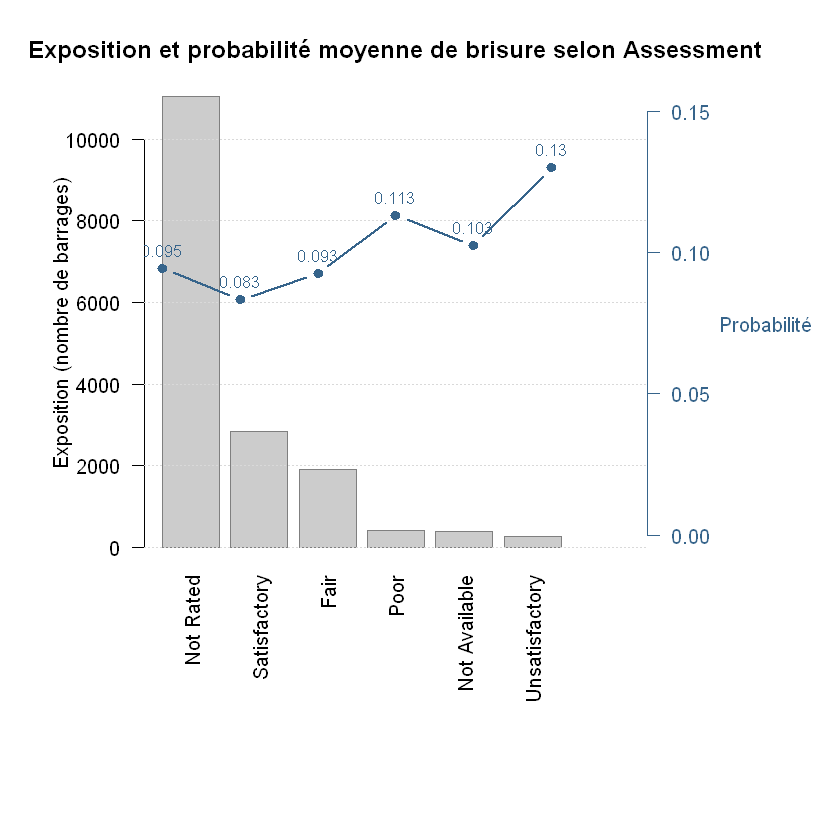

In [205]:
prob_expo_plot(df, "Assessment")

Ce graphique met en évidence une gradation nette du risque de brisure selon l’évaluation (Assessment), tout en soulignant le rôle central de l’exposition. La catégorie Not Rated concentre de loin la plus grande exposition du portefeuille, avec une probabilité moyenne de brisure d’environ 9,5 %, ce qui en fait un contributeur majeur au risque global malgré une évaluation absente. Parmi les barrages évalués, on observe une augmentation progressive de la probabilité de brisure à mesure que la qualité de l’évaluation se dégrade : elle est relativement faible pour les barrages jugés Satisfactory (environ 8,3 %), augmente pour Fair (9,3 %), puis devient nettement plus élevée pour Poor (11,3 %) et atteint un maximum pour Unsatisfactory (environ 13 %). La catégorie Not Available, bien que faiblement exposée, présente également une probabilité supérieure à 10 %, ce qui suggère un risque latent associé au manque d’information.

In [215]:
df$Assessment.Date[df$Assessment.Date == "."] <- NA
df$Assessment.Date <- as.Date(df$Assessment.Date, format = "%d/%m/%Y")
str(df$Assessment.Date)

 Date[1:19368], format: NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA "2011-07-20" NA NA NA NA ...


In [217]:
mean(is.na(df$Assessment.Date)) * 100 

[1] 47.61462

## Gestion des valeurs manquantes, outliers et aberrantes 

Etant donné les différences qu'il peut y avoir par Région, les données seront séparées par régions et des algorithmes d'imputations seront utilisés 

In [218]:
write.csv(df, file = "../../Données/data_analyse.csv", row.names = FALSE)